In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_dandak = np.genfromtxt('dandak2010_v1.txt', delimiter=",", dtype=float) # ismr reconstruction

In [3]:
yy_dandak = np.flip(data_dandak[:,0])
ismr_dandak = np.flip(data_dandak[:,1])

yy_dandak_ann = np.arange( np.trunc(np.min(yy_dandak))+1 ,np.trunc(np.max(yy_dandak)))
ismr_dandak_ann = np.zeros((yy_dandak_ann.shape[0]))

f = interpolate.interp1d(yy_dandak, ismr_dandak, kind='linear')
for i in range(yy_dandak_ann.shape[0]):
    ismr_dandak_ann[i] = f(yy_dandak_ann[i])


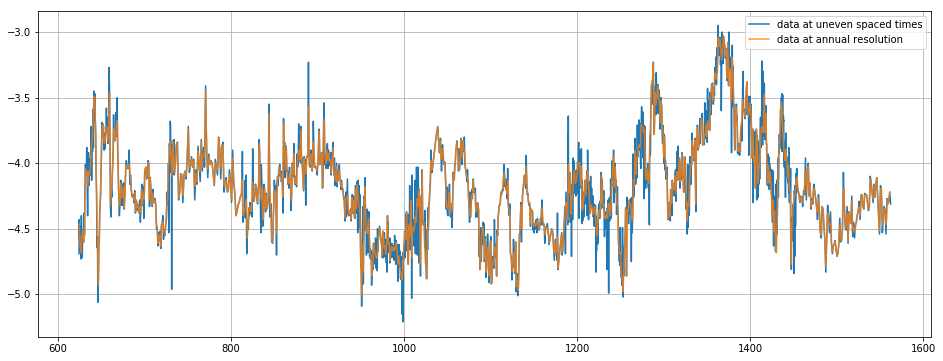

In [4]:
plt.figure(figsize=(16,6))
plt.plot(yy_dandak, ismr_dandak, label='data at uneven spaced times')
plt.plot(yy_dandak_ann, ismr_dandak_ann, label='data at annual resolution', alpha=0.8)
plt.legend()
plt.grid()

In [5]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 30# The window length. since a 30 year climatology is taken as standard
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i


In [6]:
ismr_dandak_ann_ssa = ssa(ismr_dandak_ann)

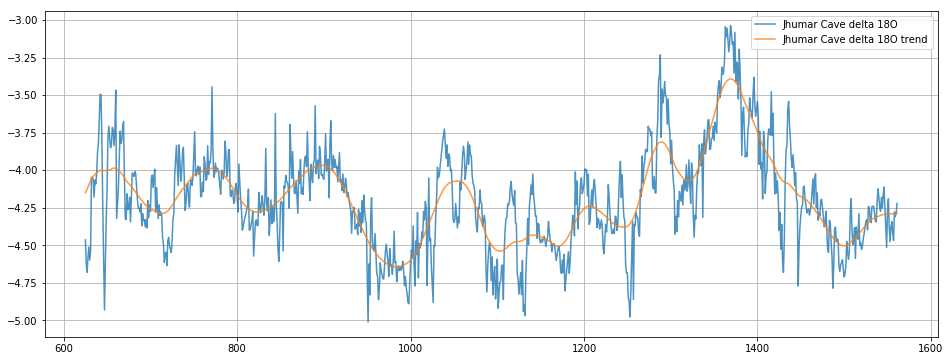

In [7]:
# Trend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_dandak_ann, ismr_dandak_ann, label='Dandak Cave delta 18O', alpha=0.8)
plt.plot(yy_dandak_ann, ismr_dandak_ann_ssa[0], label='Dandak Cave delta 18O trend', alpha=0.8)
plt.legend()
plt.grid()

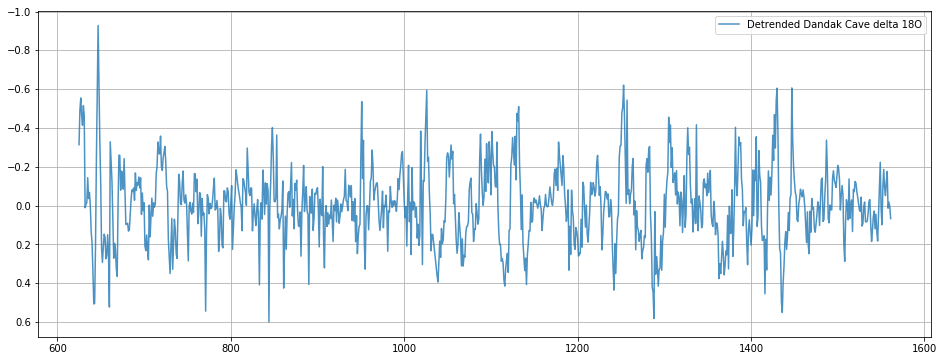

In [8]:
ismr_dandak_ann_anom = ismr_dandak_ann - ismr_dandak_ann_ssa[0]
# DeTrend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_dandak_ann, ismr_dandak_ann_anom, label='Detrended Dandak Cave delta 18O', alpha=0.8)
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

In [9]:
ismr_dandak_ann_anom_norm = (ismr_dandak_ann_anom - np.mean(ismr_dandak_ann_anom)) / (np.std(ismr_dandak_ann_anom))

In [10]:
event_drought_dandak = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_dandak_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_dandak_ann.shape[0]))

In [11]:
event_drought_dandak[ismr_dandak_ann_anom_norm>1.0] = 1.0

for i in range(yy_dandak_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_dandak_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=3.7:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [12]:
np.savetxt('drought_dandak_2010.txt', event_drought_dandak, delimiter=",")
np.savetxt('all_volc_dandak_2010.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_dandak_2010.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_dandak_2010.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_dandak_2010.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_dandak_2010.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_dandak_2010.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_dandak_2010.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_dandak_2010.txt', event_yy_volc_strong_sh, delimiter=",")

In [13]:
print(np.sum(event_yy_volc_all))
print(np.sum(event_yy_volc_strong))
print(np.sum(event_yy_volc_all_trop))
print(np.sum(event_yy_volc_strong_trop))
print(np.sum(event_yy_volc_all_nh))
print(np.sum(event_yy_volc_strong_nh))
print(np.sum(event_yy_volc_all_sh))
print(np.sum(event_yy_volc_strong_sh))

107.0
24.0
27.0
18.0
53.0
6.0
27.0
0.0


In [14]:
# Bootstrap
N = 1000
win = 5
count_elnino_all_volc = np.zeros((N, win))
count_elnino_strong_volc  = np.zeros((N, win))
count_elnino_all_trop  = np.zeros((N, win))
count_elnino_strong_trop  = np.zeros((N, win))
count_elnino_all_nh  = np.zeros((N, win))
count_elnino_strong_nh  = np.zeros((N, win))
count_elnino_all_sh  = np.zeros((N, win))

In [15]:
idx_all = np.asarray(np.where(event_yy_volc_all == 1.0))
idx_strong = np.asarray(np.where(event_yy_volc_strong == 1.0))
idx_all_trop = np.asarray(np.where(event_yy_volc_all_trop == 1.0))
idx_strong_trop = np.asarray(np.where(event_yy_volc_strong_trop == 1.0))
idx_all_nh = np.asarray(np.where(event_yy_volc_all_nh == 1.0))
idx_strong_nh = np.asarray(np.where(event_yy_volc_strong_nh == 1.0))
idx_all_sh = np.asarray(np.where(event_yy_volc_all_sh == 1.0))

In [16]:
print(idx_all[0])

[  1   4   7  12  16  32  46  57  63  69  73  88  92 100 107 120 124 125
 131 139 152 157 175 192 194 197 202 210 212 216 228 234 244 251 254 255
 275 279 283 291 304 314 321 328 333 335 345 351 357 365 373 378 386 392
 395 403 414 432 439 442 467 483 490 493 502 512 546 555 557 566 575 585
 597 605 611 633 637 644 651 661 681 704 711 716 720 753 756 764 783 789
 791 816 823 828 833 838 845 852 853 855 877 880 887 903 912 916 929]


In [17]:
ismr_dandak_ann_anom_norm = -ismr_dandak_ann_anom_norm
niter = 0
while niter<N:
    rand_year_all = random.sample(list(idx_all[0]), 1)
    if (rand_year_all[0]<ismr_dandak_ann_anom_norm.shape[0]-win):
        count_elnino_all_volc[niter,:] = ismr_dandak_ann_anom_norm[rand_year_all[0]:rand_year_all[0]+win]
    
    rand_year_strong = random.sample(list(idx_strong[0]), 1)
    if (rand_year_strong[0]<ismr_dandak_ann_anom_norm.shape[0]-win):
        count_elnino_strong_volc[niter,:] = ismr_dandak_ann_anom_norm[rand_year_strong[0]:rand_year_strong[0]+win]
    
    rand_year_all_trop = random.sample(list(idx_all_trop[0]), 1)
    if (rand_year_all_trop[0]<ismr_dandak_ann_anom_norm.shape[0]-win):
        count_elnino_all_trop[niter,:] = ismr_dandak_ann_anom_norm[rand_year_all_trop[0]:rand_year_all_trop[0]+win]

    rand_year_strong_trop = random.sample(list(idx_strong_trop[0]), 1)
    if (rand_year_strong_trop[0]<ismr_dandak_ann_anom_norm.shape[0]-win):
        count_elnino_strong_trop[niter,:] = ismr_dandak_ann_anom_norm[rand_year_strong_trop[0]:rand_year_strong_trop[0]+win]

    rand_year_all_nh = random.sample(list(idx_all_nh[0]), 1)
    if (rand_year_all_nh[0]<ismr_dandak_ann_anom_norm.shape[0]-win):
        count_elnino_all_nh[niter,:] = ismr_dandak_ann_anom_norm[rand_year_all_nh[0]:rand_year_all_nh[0]+win]

    rand_year_strong_nh = random.sample(list(idx_strong_nh[0]), 1)
    if (rand_year_strong_nh[0]<ismr_dandak_ann_anom_norm.shape[0]-win):
        count_elnino_strong_nh[niter,:] = ismr_dandak_ann_anom_norm[rand_year_strong_nh[0]:rand_year_strong_nh[0]+win]

    rand_year_all_sh = random.sample(list(idx_all_sh[0]), 1)
    if (rand_year_all_sh[0]<ismr_dandak_ann_anom_norm.shape[0]-win):
        count_elnino_all_sh[niter,:] = ismr_dandak_ann_anom_norm[rand_year_all_sh[0]:rand_year_all_sh[0]+win]
    
    #print(s[rand_year_all[0]:rand_year_all[0]+win])
    #print(rand_year_all[0])
    niter = niter + 1 

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


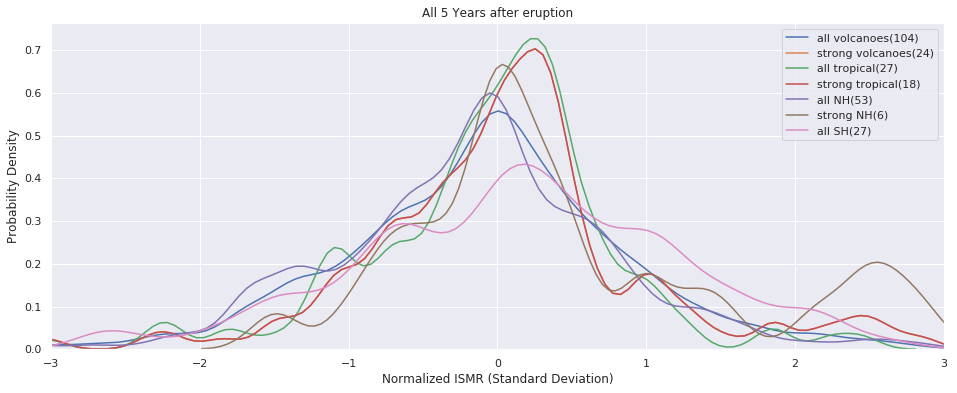

In [18]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc.flatten(), label='all volcanoes(104)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong volcanoes(24)')
sns.kdeplot(count_elnino_all_trop.flatten(), label='all tropical(27)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong tropical(18)')
sns.kdeplot(count_elnino_all_nh.flatten(), label='all NH(53)')
sns.kdeplot(count_elnino_strong_nh.flatten(), label='strong NH(6)')
sns.kdeplot(count_elnino_all_sh.flatten(), label='all SH(27)')
plt.title('All 5 Years after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


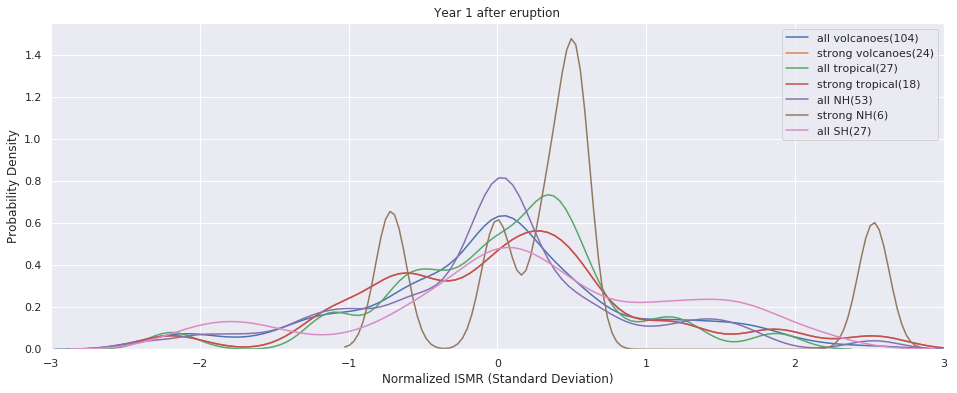

In [19]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,0], label='all volcanoes(104)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong volcanoes(24)')
sns.kdeplot(count_elnino_all_trop[:,0], label='all tropical(27)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong tropical(18)')
sns.kdeplot(count_elnino_all_nh[:,0], label='all NH(53)')
sns.kdeplot(count_elnino_strong_nh[:,0], label='strong NH(6)')
sns.kdeplot(count_elnino_all_sh[:,0], label='all SH(27)')
plt.title('Year 1 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


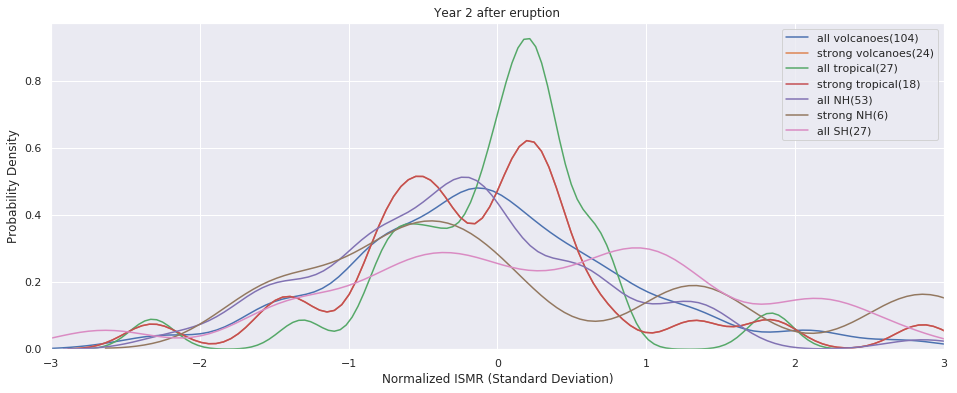

In [20]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,1], label='all volcanoes(104)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong volcanoes(24)')
sns.kdeplot(count_elnino_all_trop[:,1], label='all tropical(27)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong tropical(18)')
sns.kdeplot(count_elnino_all_nh[:,1], label='all NH(53)')
sns.kdeplot(count_elnino_strong_nh[:,1], label='strong NH(6)')
sns.kdeplot(count_elnino_all_sh[:,1], label='all SH(27)')
plt.title('Year 2 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


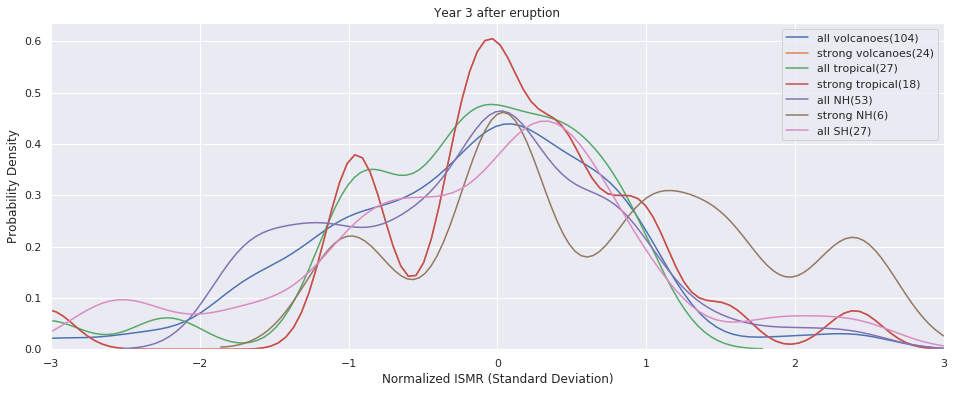

In [21]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,2], label='all volcanoes(104)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong volcanoes(24)')
sns.kdeplot(count_elnino_all_trop[:,2], label='all tropical(27)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong tropical(18)')
sns.kdeplot(count_elnino_all_nh[:,2], label='all NH(53)')
sns.kdeplot(count_elnino_strong_nh[:,2], label='strong NH(6)')
sns.kdeplot(count_elnino_all_sh[:,2], label='all SH(27)')
plt.title('Year 3 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


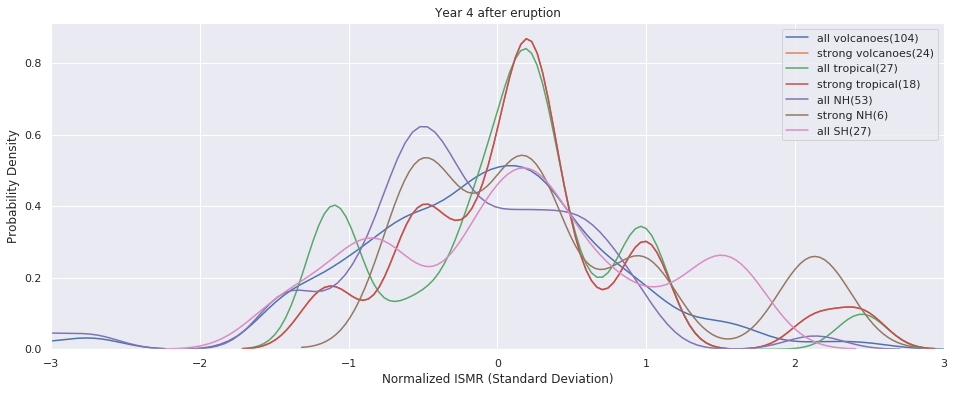

In [22]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,3], label='all volcanoes(104)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong volcanoes(24)')
sns.kdeplot(count_elnino_all_trop[:,3], label='all tropical(27)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong tropical(18)')
sns.kdeplot(count_elnino_all_nh[:,3], label='all NH(53)')
sns.kdeplot(count_elnino_strong_nh[:,3], label='strong NH(6)')
sns.kdeplot(count_elnino_all_sh[:,3], label='all SH(27)')
plt.title('Year 4 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


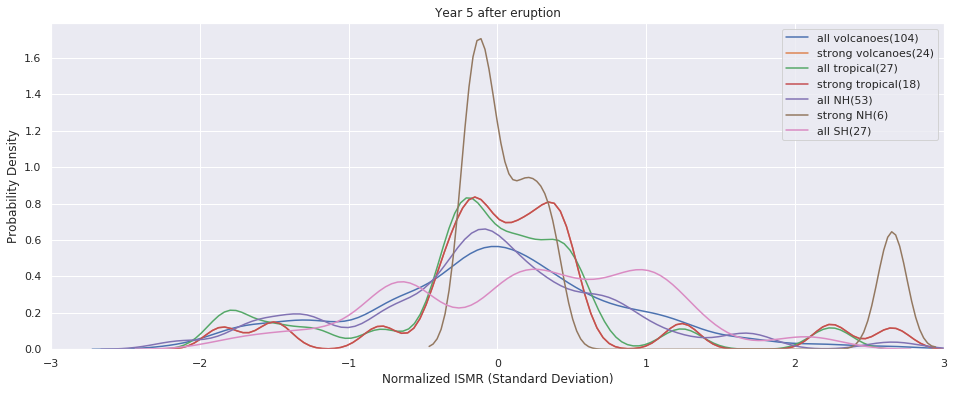

In [23]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,4], label='all volcanoes(104)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong volcanoes(24)')
sns.kdeplot(count_elnino_all_trop[:,4], label='all tropical(27)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong tropical(18)')
sns.kdeplot(count_elnino_all_nh[:,4], label='all NH(53)')
sns.kdeplot(count_elnino_strong_nh[:,4], label='strong NH(6)')
sns.kdeplot(count_elnino_all_sh[:,4], label='all SH(27)')
plt.title('Year 5 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()